
Introduction background
===

In this notebook we will demonstrate mean curvature flow to compute the equilibrium geometry of Sessile droplets. this notebook uses the data from Murray et al. (2020)  J. Appl. Phys. 128, 035101 (2020); doi: 10.1063/5.0005239.

This notebook is subdivided into 3 sections:

### 1. Imports and functions

Imported modules and definition of common functions used throughout the notebook

### 2. Parameters and image processing 

Processing the images of physical Sessile droplets to extract the geometries for comparison and define the physical parameters of the system.


### 3. Mean flow simulation

The differential energy of a starting complex is computed by $\delta E=2 H N d A$, in addition the equation of state computes the density at the new pressure which is used to preserve the volume of a given droplet mass. The vertices of the equilibrium simplicial complex should match the geometries of the Sessile droplets, subject only to the boundary integration error.


# 1. Imports and functions

First we define the imports and functions to be used. The first block contains some of the less common libraries that can be installed with jupyter by simply running the cell.

In [5]:
# scikit-image is used for image processing:
try:
    from skimage import data, io
    import skimage
except ImportError:
    import sys
    !{sys.executable} -m pip install scikit-image

# NOTE: CP is an API for the NIST database used for the water Equation of State:
try: 
    from CoolProp.CoolProp import PropsSI
except ImportError:
    import sys
    !{sys.executable} -m pip install coolprop


Defaulting to user installation because normal site-packages is not writeable
  Using cached CoolProp-6.4.1.tar.gz (12.9 MB)
Using legacy 'setup.py install' for coolprop, since package 'wheel' is not installed.
    Running setup.py install for coolprop ... error
    ERROR: Command errored out with exit status 1:
     command: /usr/bin/python3 -u -c 'import sys, setuptools, tokenize; sys.argv[0] = '"'"'/tmp/pip-install-l3x5hbwn/coolprop_444df2e63873408e8b3da2007c44f7e0/setup.py'"'"'; __file__='"'"'/tmp/pip-install-l3x5hbwn/coolprop_444df2e63873408e8b3da2007c44f7e0/setup.py'"'"';f=getattr(tokenize, '"'"'open'"'"', open)(__file__);code=f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' install --record /tmp/pip-record-f6h9xg44/install-record.txt --single-version-externally-managed --user --prefix= --compile --install-headers /home/endres/.local/include/python3.9/coolprop
         cwd: /tmp/pip-install-l3x5hbwn/coolprop_444df2e63873408e8

In [4]:

# Imports and physical parameters
import copy
import sys
import numpy as np
import scipy
#from matplotlib import pyplot as plt
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d
%matplotlib notebook

# Local library 
# Allow for relative imports from main library:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from ddgclib import *
from ddgclib._complex import Complex
#from ddgclib.curvatures import plot_surface, curvature

    

# Equation of state for water droplet:
def eos(P=101.325, T=298.15):
    # P in kPa T in K 
    return PropsSI('D','T|liquid',298.15,'P',101.325,'Water') # density kg /m3

# Surface tension of water gamma(T):
def IAPWS(T=298.15): 
    T_C = 647.096  # K, critical temperature
    return 235.8e-3 * (1 -(T/T_C))**1.256 * (1 - 0.625*(1 - (T/T_C)))  # N/m

T_0 = 273.15 + 25  # K, initial tmeperature
P_0 = 101.325  # kPa, Ambient pressure
gamma = IAPWS(T_0)  # N/m, surface tension of water at 20 deg C
rho_0 = eos(P=P_0, T=T_0)  # kg/m3, density
g = 9.81  # m/s2

from ddgclib import *
from ddgclib._complex import Complex
#from ddgclib.curvatures import plot_surface, curvature

# Colour scheme for surfaces
db = np.array([129, 160, 189]) / 255  # Dark blue
lb = np.array([176, 206, 234]) / 255  # Light blue

NameError: name 'PropsSI' is not defined

In [ ]:
def mean_flow(HC, bV, m_0, tau=0.5, h_0=0.0, gravity_field=True):
    """
    Compute a single iteration of mean curvature flow
    :param HC: Simplicial complex
    :param bV: A set of boundary vertices
    :param m_0: The initial mass of the water droplet
    :return:
    
        
    # Test changes for errors:
    mean_flow(HC, bV, 1.0, tau=0.01)
    
    """
    # Define the normals (NOTE: ONLY WORKS FOR CONVEX SURFACES(?))
    # Note that the cache HC.V is an OrderedDict:
    N = []

    V = set(HC.V) - bV
    V_a = []
    f = []
    
    for v in V:
        f.append(v.x_a)
        
    f = np.array(f)
    #COM = numpy.average(nonZeroMasses[:,:3], axis=0, weights=nonZeroMasses[:,3])
    com = np.average(f, axis=0)
    #print(f'com = {com}')
    for v in V:         
        N.append(normalized(v.x_a - com)[0])
    
    NdA = []
    HNdA = []
    HN = []  # sum(HNdA_ij, axes=0) / C_ijk
    C = []
    for i, v in enumerate(V):
        F, nn = vectorise_vnn(v)
        try:
            c_outd = curvatures(F, nn, n_i=N[i])
        except IndexError:
            print(f'WARNING, IndexError in loop')
            c_outd = {}
            c_outd['HNdA_i'] = np.zeros(3)
            c_outd['C_ijk'] = np.array([1.0])
            c_outd['NdA_i'] = np.zeros(3)
            
        NdA.append(c_outd['NdA_i'])
        HN.append(c_outd['HNdA_i']/np.sum(c_outd['C_ijk']))
        C.append(np.sum(c_outd['C_ijk']))
        #f.append(v.x_a)

    H = np.nan_to_num(-np.array(HN))
    NdA = np.nan_to_num(np.array(NdA))
    dP = -gamma * H  # Hydrostatic pressure
    
    # Add volume perservation
    # First note that the volume gradient points in the same direction as the 
    # vector area NV (i.e. they are the same up to a constant factor).
    # Therefore we simply need to compute the different between the current 
    # volume and the equilibrium volume and add a scalar multiplier
    Rho = []
    for dp in dP:
        #p = 101.325 + dp
        p = 101.325 + np.sum(dp)  #TODO: Validate
        #print(f'p = {p}')
        rho = eos(P=p)  # kg m-3
        Rho.append(rho)
        # TODO: Compute local signed 
    Rho = np.array(Rho) 
    #print(f'Rho = {Rho}')
    V_eq = m_0/Rho  # m-3
    V_eq = np.mean(m_0/Rho)  # m-3
    V_eq =  0.02962e-6   # TEMPORARY
    print(f'V_eq = {V_eq}')
    
    N = np.array(N)
    #print(f'N_i = {N}')
    #print(f'NdA = {NdA}')
    if 0:
        print(f'np.sum(N) = {np.sum(N)}')
        print(f'np.sum(NdA) = {np.sum(NdA)}')
        print(f'np.sum(NdA*N) = {np.sum(NdA*N)}')
        print(f'NdA.dot(N) = {NdA.T.dot(N)}')
        print(f'sum NdA.dot(N) = {np.sum(NdA.T.dot(N))}')
    
    V_current = np.sum(C)/6.0
    print(f'V_current = {V_current}')
    #dV =  -(V_current - V_eq)*H
    V_current = V_eq *0.9   # TEMPORARY
    dV = 2* 6*(V_eq - V_current)*N
    
    # Add gravity force rho * g * h (Validated)
    if gravity_field:
        h = f[:, 2] - h_0
        g_v = np.zeros_like(dP)
        g_v[:, 2] = -g
        dg = rho*(h*g_v.T).T
    else:
        dg = np.zeros_like(dP)
    
    #dV = np.zeros_like(dP)
    
    df = dP + dV + dg
    #print(f'df = {df}')
    f_k = f + tau * df
    #print(f'df = {df}')
    for i, v in enumerate(V):
        #print(f'f_k[i] = {f_k[i]}')
        HC.V.move(HC.V[tuple(v.x_a)], tuple(f_k[i]))

    return HC

In [25]:
def Gauss_Bonnet(HC):
    """
    Compute a single iteration of mean curvature flow
    :param HC: Simplicial complex
    :return:


    """
    ## Computer Euler Characteristic:
    # Compute the number of vertices
    V = len(list(HC.V))
    # Compute the dges
    E = 0
    for v in HC.V:
        E += len(list(v.nn))
        
    E = E/2.0 # We have added precisely twice the number of edges through adding each connection
    # Compute the faces
    HC.dim = 2  # We have taken the boundary of the sphere
    HC.vertex_face_mesh()
    Faces = HC.simplices_fm
    F = len(Faces)
    
    # Compute Euler
    chi = V - E + F
    print(f'V = {V}')
    print(f'E = {E}')
    print(f'F = {F}')
    chi = V - E + F
    print(f'$\chi = V - E + F$ = {chi}')   
    
    
    return 

In [26]:
def regularize(HC, bV, tau_i=1e-1):
    """
    TODO: We need a solution for when the mesh has already degenerated 
          and np.min([minVn_norm, tau_glob]) = 0.0
    """
    V = set(HC.V) - bV
    f = []
    for v in V:
        f.append(v.x_a)
        
    f = np.array(f)
    V_corr = []
    tau_glob = np.inf
    for i, v in enumerate(V):
        Vn = []
        for vn in v.nn:
            Vn.append(vn.x_a - v.x_a)
        Vn = np.array(Vn)
        Vn_norm = np.linalg.norm(Vn, axis=1)
        maxVn_norm = np.max(np.linalg.norm(Vn, axis=1))
        minVn_norm = np.min(np.linalg.norm(Vn, axis=1))
        tau_glob = np.min([minVn_norm, tau_glob])
        meanvn_norm = np.mean(Vn_norm)
        v_corr = np.zeros_like(Vn[0])
        for vn, vn_norm in zip(Vn, Vn_norm):
            #print(f'v_corr = {v_corr}')
            if vn_norm >= meanvn_norm:
                c = minVn_norm - vn_norm
            else:
                c = maxVn_norm - vn_norm

            #print(f'c ={c}')
            v_corr = v_corr - c * vn
            #df[i] += 100 *c * vn

        np.sum(v_corr, axis=-1)    
        V_corr.append(v_corr)
    
    tau = tau_glob
    V_corr = np.array(V_corr)
    df = V_corr
    f_k = f + tau * df
    print(f' tau  = { tau }')
    for i, v in enumerate(V):
        #print(f'f_k[i] = {f_k[i]}')
        HC.V.move(HC.V[tuple(v.x_a)], tuple(f_k[i]))
        
    return HC

# 2. Parameters and image processing 


### Parameters (also used in simulation)

NOTE: They assume in the paper that the volume is a spherical cap, this is a _bad_ assumption, unfortunately they did not measure the initial mass of the droplet. We should remember to note that we expect a large experimental error in our own results.

In this figure both measurement methods (called M1 and M2 by the authors) coincide at our measured time


In [27]:
# Find the Abscissa using scale interpolations
voxels = 126  # Voxels between 100 and 200 in 4.c
voxels_m =  126 * (33/100.0)

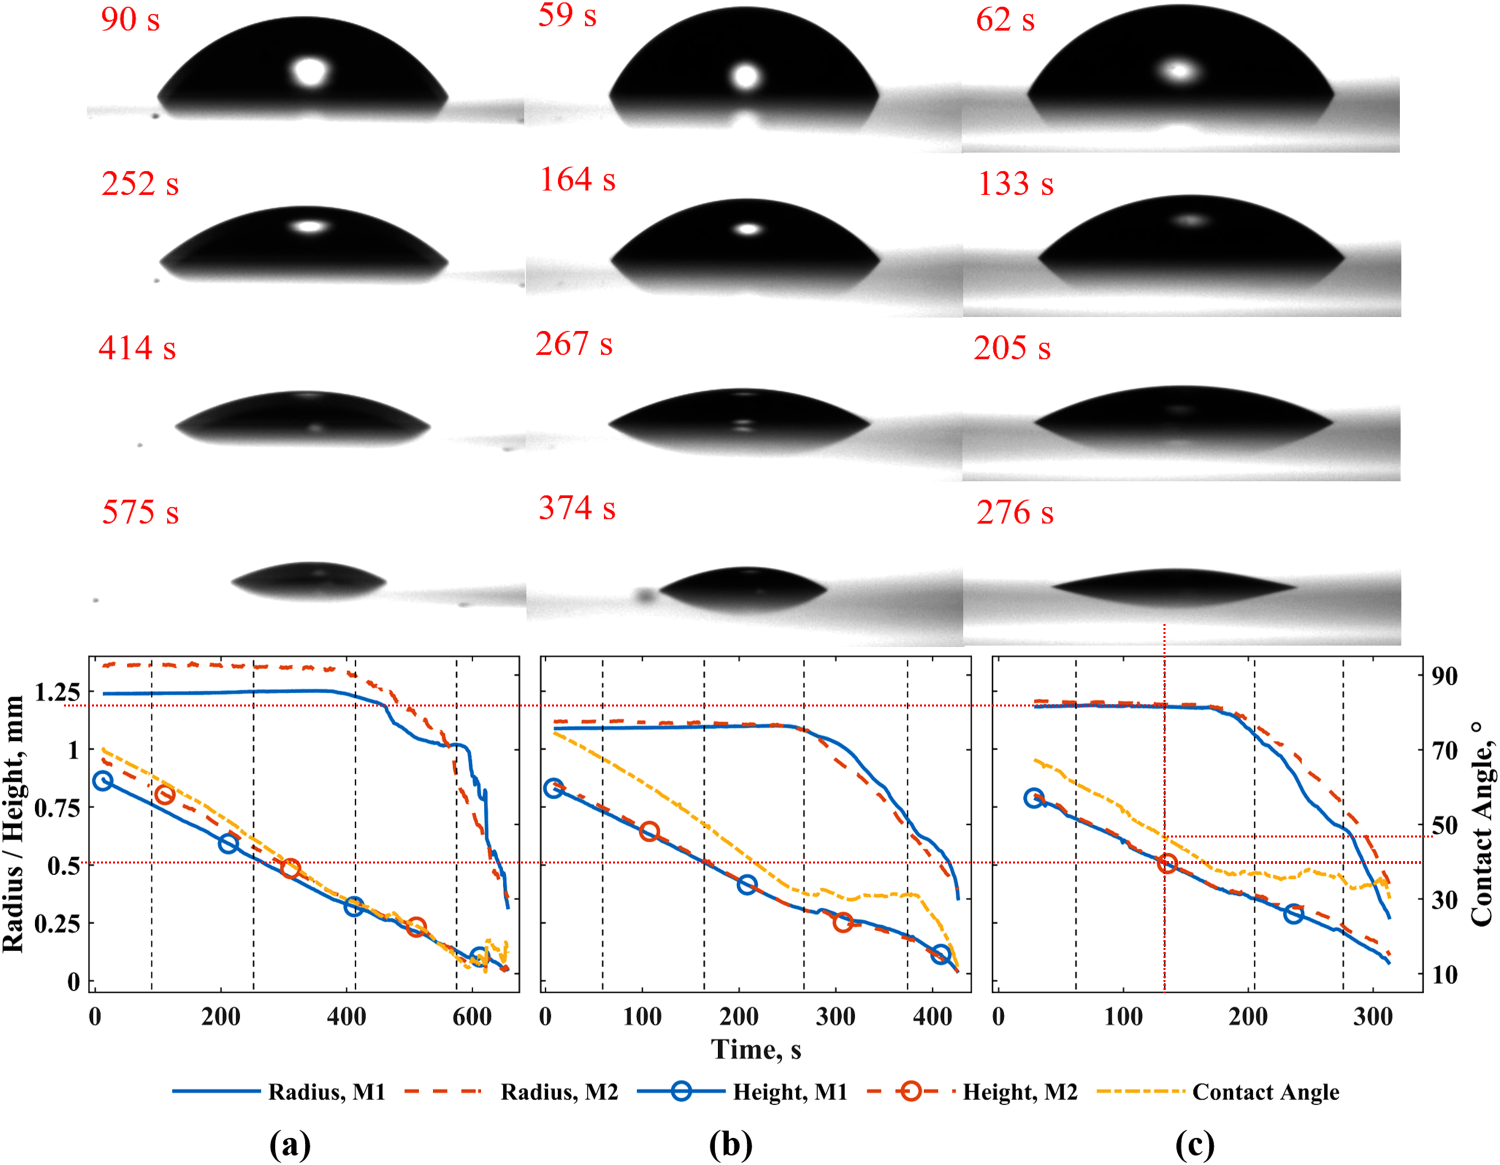

In [28]:
# Fig. 5 is the droplet at 133 s, we read off the contact angle, radius and heigh from Fig. 4.c
# The ratios below are the voxel fractions of where we read off the scales:

theta_p = (63/75) * 20 + 30
theta_p = theta_p* np.pi /180.0
r = ((44/58)* 0.25 + 1.0) * 1e-3  # height mm --> m  # Radius
h = ((3/58)* 0.25 + 0.5) * 1e-3  # height mm --> m
v = np.pi*(3 * r**2 * h + h**3)/6.0  # Volume in m3 (Segment of a sphere, see note above)
Volume, V = v, v

print(f'theta_p = {theta_p*180.0/ np.pi}')
print(f'r = {r * 1e3} mm')
print(f'h = {h * 1e3} mm')
print(f'V = {V * 1e9} mm^3')

theta_p = 46.79999999999999
r = 1.1896551724137934 mm
h = 0.5129310344827587 mm
V = 1.2109653627539805 mm^3


In [29]:
# Other parameters from model@
T_0 = 273.15 + 40  # K, tmeperature # 40 Deg C
P_0 = 101.325  # kPa, Ambient pressure #TODO: CHECK THIS FOR MURRAY STUDY!!!
gamma = IAPWS(T_0)  # N/m, surface tension of water at 20 deg C
rho_0 = eos(P=P_0, T=T_0)  # kg/m3, density
m_0 = rho_0 * Volume  # kg, initial mass (kg/m3 * m3)
g = 9.81  # m/s2

### Process cropped image

<IPython.core.display.Javascript object>


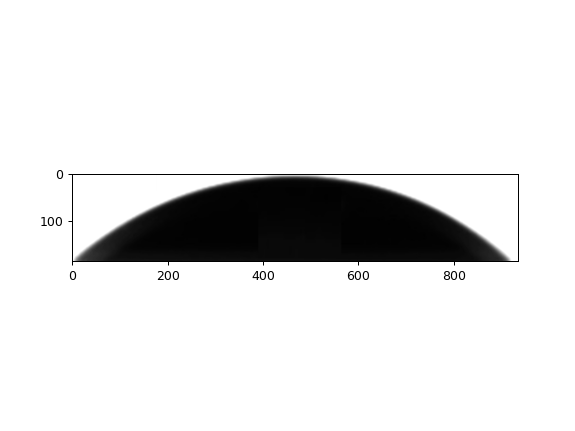

In [30]:
img_str = './data/hydrophillic_cropped_murray.png'
I_png=plt.imread(img_str)
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])
gray = rgb2gray(I_png)    
plt.imshow(gray, cmap=plt.get_cmap('gray'), vmin=0, vmax=1)
plt.show()


In [31]:
scale = 189  # voxels / 0.5 mm  (from the bar given in the paper)
scale = 189 / 0.5  # voxels /  mm
scale

378.0

In [32]:
np.max(gray), np.min(gray)

(0.9998999999999999, 0.003921176702482626)

In [33]:
import skimage
import skimage.feature
import skimage.viewer
import sys

# read command-line arguments
#filename = sys.argv[1]
filename =img_str
#sigma = 0.2
#low_threshold = float(sys.argv[3])
#high_threshold = float(sys.argv[4])
sigma = 5.0#2.0
sigma = 10.0#2.0
low_threshold = 0.1
high_threshold = 0.3

image = skimage.io.imread(fname=filename, as_gray=True)
#viewer = skimage.viewer(image=image)
viewer = skimage.viewer.ImageViewer(image=image)
viewer.show()
image_cropped = image#[210:400,180:440]


In [34]:
help(skimage.io.imread)

Help on function imread in module skimage.io._io:

imread(fname, as_gray=False, plugin=None, flatten=None, **plugin_args)
    Load an image from file.
    
    Parameters
    ----------
    fname : string
        Image file name, e.g. ``test.jpg`` or URL.
    as_gray : bool, optional
        If True, convert color images to gray-scale (64-bit floats).
        Images that are already in gray-scale format are not converted.
    plugin : str, optional
        Name of plugin to use.  By default, the different plugins are
        tried (starting with imageio) until a suitable
        candidate is found.  If not given and fname is a tiff file, the
        tifffile plugin will be used.
    
    Other Parameters
    ----------------
    plugin_args : keywords
        Passed to the given plugin.
    flatten : bool
        Backward compatible keyword, superseded by `as_gray`.
    
    Returns
    -------
    img_array : ndarray
        The different color bands/channels are stored in the
       

In [35]:
help(skimage.feature.canny)

Help on function canny in module skimage.feature._canny:

canny(image, sigma=1.0, low_threshold=None, high_threshold=None, mask=None, use_quantiles=False)
    Edge filter an image using the Canny algorithm.
    
    Parameters
    -----------
    image : 2D array
        Grayscale input image to detect edges on; can be of any dtype.
    sigma : float
        Standard deviation of the Gaussian filter.
    low_threshold : float
        Lower bound for hysteresis thresholding (linking edges).
        If None, low_threshold is set to 10% of dtype's max.
    high_threshold : float
        Upper bound for hysteresis thresholding (linking edges).
        If None, high_threshold is set to 20% of dtype's max.
    mask : array, dtype=bool, optional
        Mask to limit the application of Canny to a certain area.
    use_quantiles : bool, optional
        If True then treat low_threshold and high_threshold as quantiles of the
        edge magnitude image, rather than absolute edge magnitude valu

In [36]:
sigma = 2.0
#sigma = 5.0
#sigma = 5.5
#low_threshold = 0.2#0.66#0.05 
low_threshold = 0.001#0.05 
#low_threshold = 0.2#0.05 
high_threshold = 0.50

#max, min pair was = (0.4862258831709623, 0.0)
edges = skimage.feature.canny(
    image=image_cropped,
    sigma=sigma,
    low_threshold=low_threshold,
    high_threshold=high_threshold,
)
viewer = skimage.viewer.ImageViewer(edges)
viewer.show()

[]

In [37]:
edges.shape, image_cropped.shape

((183, 936), (183, 936))

In [38]:
ypos, xpos = np.argwhere(edges)[:, 0], np.argwhere(edges)[:, 1]
xpos, ypos

(array([437, 438, 439, ..., 915,   7, 915], dtype=int64),
 array([  6,   6,   6, ..., 180, 181, 181], dtype=int64))

In [39]:
np.savetxt('./data/output_murray.txt', np.argwhere(edges), delimiter=';')

In [40]:
x0 = 2 + int(919/2.0)  # TODO: Detect maximum of edge contour to find symmetry automatically
y0 = 2 + image_cropped.shape[0]
x = (xpos - x0)/scale  # voxels --> mm
y = (-ypos + y0)/scale  # voxels --> mm

In [41]:
(xpos - x0)

array([ -24,  -23,  -22, ...,  454, -454,  454], dtype=int64)

<IPython.core.display.Javascript object>


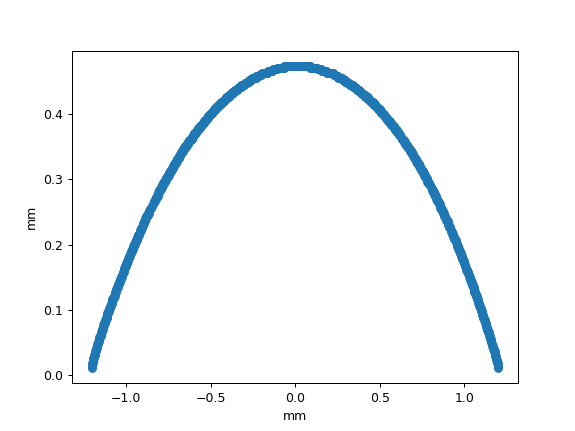

Text(0, 0.5, 'mm')

In [42]:
plt.figure()
plt.scatter(x, y)
plt.xlabel('mm')
plt.ylabel('mm')

Mean flow simulation
===

First we try a cylinder to droplet flow.

Initiate the cylinder:

In [43]:
h_cylinder =  V / ( np.pi * r**2 )  # V =  np.pi * r**2 * h 
h_cylinder, h, r

(0.00027235769758538603, 0.0005129310344827587, 0.0011896551724137933)

<IPython.core.display.Javascript object>


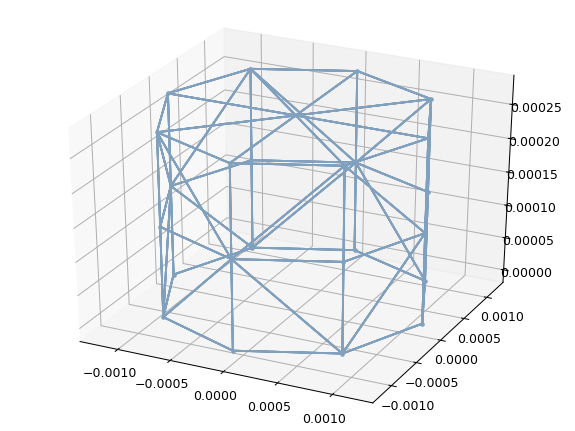

In [47]:
# Initiate a cubical complex
HC = Complex(3, domain=[(-r, r),]*3)
HC.triangulate()

for i in range(1):
    HC.refine_all()

#for v in HC2V:
#    HC.refine_star(v)
del_list = []
for v in HC.V:
    if np.any(v.x_a == -r) or np.any(v.x_a == r):
        if np.any(v.x_a[2] == -r):
            if np.any(v.x_a[0:2] == -r) or  np.any(v.x_a[0:2] == r):
                continue
            else:
                del_list.append(v)
        else:
            continue    
    else:
        del_list.append(v)

for v in del_list:
    HC.V.remove(v)

# Shrink to circle and move to zero
for v in HC.V:
    x = v.x_a[0]
    y = v.x_a[1]
    f_k = [x * np.sqrt(r**2 - y**2/2.0)/r, y * np.sqrt(r**2 - x**2/2.0)/r, v.x_a[2]]
    HC.V.move(v, tuple(f_k)) 
    
# Move up to zero (NOTE: DO NOT DO THIS IN THE CIRCLE LOOP 
# BECUASE SAME VERTEX INDEX BREAKS CONNECTIONS IN LOOP DURING MOVE: 
# TODO: FIX THIS IN THE hyperct LIBRARY CODE)
for v in HC.V:
    if (v.x_a[2] == -r) or (v.x_a[2] == 0.0):
        continue
    f_k = [v.x_a[0], v.x_a[1], v.x_a[2] + r]
    HC.V.move(v, tuple(f_k))  
    
for v in HC.V:
    if (v.x_a[2] == 2*r) or (v.x_a[2] == -r):
        continue
    f_k = [v.x_a[0], v.x_a[1], v.x_a[2] + r]
    HC.V.move(v, tuple(f_k))       
    
for v in HC.V:
    if (v.x_a[2] == 2*r) or (v.x_a[2] == r):
        continue
    f_k = [v.x_a[0], v.x_a[1], v.x_a[2] + r]
    HC.V.move(v, tuple(f_k))     
    
## Move to h
for v in HC.V:
    if (v.x_a[2] == 0.0) or (v.x_a[2] == r):
        continue
    f_k = [v.x_a[0], v.x_a[1], v.x_a[2] + h_cylinder - 2*r]
    HC.V.move(v, tuple(f_k))  
    
for v in HC.V:
    if (v.x_a[2] == r):
        f_k = [v.x_a[0], v.x_a[1], v.x_a[2] + 0.5*h_cylinder - r]
        HC.V.move(v, tuple(f_k))  
    
# Find set of boundary vertices
bV = set()
for v in HC.V:
    #print('-')
    #print(f'v.x_a = {v.x_a}')
    #print(f'v.x_a[2] == 0.0 = {v.x_a[2] == 0.0}')
    if v.x_a[2] == 0.0:
        bV.add(v)
        #print(f'bV = {bV}')
    else:
        continue

%matplotlib notebook
fig, axes, fig_s, axes_s = HC.plot_complex(point_color=db,
                                           line_color=db,
                                           complex_color_f=lb,
                                           complex_color_e=db
                                           )

#axes.set_xlim3d(-(0.1*r + r) , 0.1*r + r)
#axes.set_ylim3d(-(0.1*r + r) , 0.1*r + r)
#axes.set_zlim3d(-(0.1*r + r) , 0.1*r + 2*r)

### Explain how to reproduce figures for higher refinements.

### NOTE: The next series of cells contains volume calculations and sanity checks

In [45]:
## Compute volume
# Compute COM
f = []
for v in HC.V:
    f.append(v.x_a)

f = np.array(f)
#COM = numpy.average(nonZeroMasses[:,:3], axis=0, weights=nonZeroMasses[:,3])
com = np.average(f, axis=0)
com

bf = []
for v in bV:
    bf.append(v.x_a)

bf = np.array(bf)
#COM = numpy.average(nonZeroMasses[:,:3], axis=0, weights=nonZeroMasses[:,3])
bcom = np.average(bf, axis=0)
bcom

HC2 = copy.copy(HC)
for v in HC2.V:
    v.connect(HC2.V[tuple(com)])
    
for v in bV:
    v.connect(HC2.V[tuple(bcom)])

HC2.V[tuple(com)].connect(HC2.V[tuple(bcom)])
# Compute simplices:
HC2.vertex_face_mesh()   
HC2.simplices_fm

[[(-0.0008412132396874445, -0.0008412132396874445, 0.0),
  (0.0, -0.0011896551724137933, 0.00027235769758538614),
  (0.0008412132396874445, -0.0008412132396874445, 0.00013617884879269307),
  (0.0, 0.0, 0.0001416260027444008)],
 [(-0.0008412132396874445, -0.0008412132396874445, 0.0),
  (-0.0008412132396874445, -0.0008412132396874445, 0.00013617884879269307),
  (0.0, 0.0, 0.0001416260027444008),
  (0.0, -2.710505431213761e-20, 0.0)],
 [(-0.0008412132396874445, -0.0008412132396874445, 0.0),
  (0.0008412132396874445, 0.0008412132396874445, 0.00027235769758538614),
  (-0.0008412132396874445, -0.0008412132396874445, 0.00027235769758538614),
  (0.0, 0.0, 0.0001416260027444008)],
 [(-0.0008412132396874445, -0.0008412132396874445, 0.0),
  (0.0, -0.0011896551724137933, 0.00027235769758538614),
  (-0.0008412132396874445, -0.0008412132396874445, 0.00013617884879269307),
  (0.0, 0.0, 0.0001416260027444008)],
 [(-0.0008412132396874445, -0.0008412132396874445, 0.0),
  (0.0008412132396874445, 0.000841

In [46]:
%matplotlib notebook
fig, axes, fig_s, axes_s = HC2.plot_complex(point_color=db,
                                           line_color=db,
                                           complex_color_f=lb,
                                           complex_color_e=db
                                           )

In [252]:
bcom

array([0.        , 0.        , 0.00014163])

In [257]:
for s in HC2.simplices_fm:
    print(tuple(com) in set(s))

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
False
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
False
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


In [258]:
def tet_vol(s): 
    """
    Code stolen from https://stackoverflow.com/questions/9866452/calculate-volume-of-any-tetrahedron-given-4-points
    """
    def determinant_3x3(m):
        return (m[0][0] * (m[1][1] * m[2][2] - m[1][2] * m[2][1]) -
                m[1][0] * (m[0][1] * m[2][2] - m[0][2] * m[2][1]) +
                m[2][0] * (m[0][1] * m[1][2] - m[0][2] * m[1][1]))


    def subtract(a, b):
        return (a[0] - b[0],
                a[1] - b[1],
                a[2] - b[2])

    def tetrahedron_calc_volume(a, b, c, d):
        return (abs(determinant_3x3((subtract(a, b),
                                     subtract(b, c),
                                     subtract(c, d),
                                     ))) / 6.0)
    a = s[0]
    d = s[1]
    c = s[2]
    b = s[3]

    #print(tetrahedron_calc_volume(a, b, c, d))
    return tetrahedron_calc_volume(a, b, c, d)

In [259]:
tet_vol(HC2.simplices_fm[0])

5.536764691700023e-11

In [265]:
V_complex = 0.0
for s in HC2.simplices_fm:
    if tuple(com) in set(s):
        V_complex += tet_vol(s)
    
V_complex, V,  h_cylinder * np.pi * r**2 

(3.095711592164334e-09, 1.2109653627539804e-09, 1.2109653627539804e-09)

In [263]:
V_complex/2.0

1.547855796082167e-09

In [241]:
def complex_vol(HC):
    ## Compute volume of HC
    # Compute COM
    f = []
    HC2 = copy.copy(HC)
    for v in HC.V:
        f.append(v.x_a)

    f = np.array(f)
    #COM = numpy.average(nonZeroMasses[:,:3], axis=0, weights=nonZeroMasses[:,3])
    com = np.average(f, axis=0)
    com

    # Compute simplices:
    HC.vertex_face_mesh()
    HC.simplices_fm


### Sanity checks:

In [242]:
# Check boundary set arithmetic:
set(HC.V), set(HC.V) - bV

({<ddgclib._vertex.VertexCube at 0x1f3d24870c8>,
  <ddgclib._vertex.VertexCube at 0x1f3d2ffabc8>},
 {<ddgclib._vertex.VertexCube at 0x1f3d24870c8>,
  <ddgclib._vertex.VertexCube at 0x1f3d2ffabc8>})

In [217]:
#%% Check cache and boundary set sizes
len(set(HC.V)), len(set(bV)), len(set(HC.V) - bV)

(25, 8, 17)

In [218]:
#%%
HC.V.print_out()

Vertex cache of size: 25:
Vertex: (-0.0008412132396874445, -0.0008412132396874445, 0.0)
Connections: (-0.0008412132396874445, -0.0008412132396874445, 0.00013617884879269307) (0.0, -0.0011896551724137933, 0.0) (-0.0011896551724137933, 0.0, 0.0) (0.0, -0.0011896551724137933, 0.00013617884879269307) (-0.0011896551724137933, 0.0, 0.00013617884879269307) 
Vertex: (0.0008412132396874445, -0.0008412132396874445, 0.0)
Connections: (0.0011896551724137933, 0.0, 0.0) (0.0008412132396874445, -0.0008412132396874445, 0.00013617884879269307) (0.0, -0.0011896551724137933, 0.0) (0.0011896551724137933, 0.0, 0.00013617884879269307) (0.0, -0.0011896551724137933, 0.00013617884879269307) 
Vertex: (-0.0008412132396874445, 0.0008412132396874445, 0.0)
Connections: (-0.0008412132396874445, 0.0008412132396874445, 0.00013617884879269307) (0.0, 0.0011896551724137933, 0.0) (-0.0011896551724137933, 0.0, 0.0) (0.0, 0.0011896551724137933, 0.00013617884879269307) (-0.0011896551724137933, 0.0, 0.00013617884879269307) 
V

In [219]:
#%%
V_defective = [HC.V[(0.0, -r, 0.0)],   HC.V[(0.0, r, 0.0)], HC.V[(-r, 0.0, 0.0)], HC.V[( r, 0.0, 0.0)]]  
for v in V_defective:
    print(v)
    print(f'v.nn = {v.nn}')

v.nn = {<ddgclib._vertex.VertexCube object at 0x000001F3D2867D48>, <ddgclib._vertex.VertexCube object at 0x000001F3D2867E48>, <ddgclib._vertex.VertexCube object at 0x000001F3D286A188>}
v.nn = {<ddgclib._vertex.VertexCube object at 0x000001F3D2868348>, <ddgclib._vertex.VertexCube object at 0x000001F3D2868308>, <ddgclib._vertex.VertexCube object at 0x000001F3D286A248>}
v.nn = {<ddgclib._vertex.VertexCube object at 0x000001F3D2867D48>, <ddgclib._vertex.VertexCube object at 0x000001F3D2868308>, <ddgclib._vertex.VertexCube object at 0x000001F3D286A1C8>}
v.nn = {<ddgclib._vertex.VertexCube object at 0x000001F3D2868348>, <ddgclib._vertex.VertexCube object at 0x000001F3D2867E48>, <ddgclib._vertex.VertexCube object at 0x000001F3D286A208>}


In [105]:
# Ensure the norm is correct
print(f'Norm test (all should be equal to r = {r}):')
for v in HC.V:
    print(f'v.x_a = {v.x_a}')
    #print(f'v in bHC_V: {v in bHC_V}')
    print(f'norm = {np.linalg.norm(v.x_a - HC.V[(0.0, 0.0, 0.0)].x_a)}')
# Ensure that the boundary doesn't contain the origin
print(f'Boundary test:')
for v in bV:
    print(f'v.x_a = {v.x_a}')
    if np.linalg.norm(v.x_a - HC.V[(0.0, 0.0, 0.0)].x_a) in bV:
        print(f'FAILURE: ORIGIN in bHC_V')

Norm test (all should be equal to r = 0.0010129310344827588):
v.x_a = [-0.00071625 -0.00071625  0.        ]
norm = 0.0010129310344827588
v.x_a = [ 0.00071625 -0.00071625  0.        ]
norm = 0.0010129310344827588
v.x_a = [-0.00071625  0.00071625  0.        ]
norm = 0.0010129310344827588
v.x_a = [0.00071625 0.00071625 0.        ]
norm = 0.0010129310344827588
v.x_a = [ 0.         -0.00101293  0.        ]
norm = 0.0010129310344827588
v.x_a = [-0.00101293  0.          0.        ]
norm = 0.0010129310344827588
v.x_a = [0.00101293 0.         0.        ]
norm = 0.0010129310344827588
v.x_a = [0.         0.00101293 0.        ]
norm = 0.0010129310344827588
v.x_a = [0.00071625 0.00071625 0.00068966]
norm = 0.0012254197392956468
v.x_a = [-0.00071625 -0.00071625  0.00068966]
norm = 0.0012254197392956468
v.x_a = [ 0.00071625 -0.00071625  0.00068966]
norm = 0.0012254197392956468
v.x_a = [-0.00071625  0.00071625  0.00068966]
norm = 0.0012254197392956468
v.x_a = [0.         0.         0.00068966]
norm = 

## Mean flow simulation cylinder --> Sessile droplet

V_eq = 2.962e-08
V_current = 1.0183395655198333e-06
V_eq = 2.962e-08
V_current = 1.0157154637306582e-06
V_eq = 2.962e-08
V_current = 1.0131020036929276e-06
V_eq = 2.962e-08
V_current = 1.0104992210875639e-06
V_eq = 2.962e-08
V_current = 1.0079071512682106e-06
V_eq = 2.962e-08
V_current = 1.0053258292427547e-06
V_eq = 2.962e-08
V_current = 1.0027552896549721e-06
V_eq = 2.962e-08
V_current = 1.0001955667659363e-06
V_eq = 2.962e-08
V_current = 9.976466944353156e-07
V_eq = 2.962e-08
V_current = 9.951087061025666e-07
V_eq = 2.962e-08
V_current = 9.925816347680066e-07
V_eq = 2.962e-08
V_current = 9.900655129737932e-07
V_eq = 2.962e-08
V_current = 9.875603727848062e-07
V_eq = 2.962e-08
V_current = 9.850662457694305e-07
V_eq = 2.962e-08
V_current = 9.825831629802882e-07
V_eq = 2.962e-08
V_current = 9.80111154934868e-07
V_eq = 2.962e-08
V_current = 9.776502515961268e-07
V_eq = 2.962e-08
V_current = 9.752004823530133e-07
V_eq = 2.962e-08
V_current = 9.727618760009682e-07
V_eq = 2.962e-08
V_curre

V_eq = 2.962e-08
V_current = 7.315330353247868e-07
V_eq = 2.962e-08
V_current = 7.305309617170828e-07
V_eq = 2.962e-08
V_current = 7.295345052051875e-07
V_eq = 2.962e-08
V_current = 7.285436143767928e-07
V_eq = 2.962e-08
V_current = 7.275582386403724e-07
V_eq = 2.962e-08
V_current = 7.265783282267816e-07
V_eq = 2.962e-08
V_current = 7.256038341900248e-07
V_eq = 2.962e-08
V_current = 7.246347084072039e-07
V_eq = 2.962e-08
V_current = 7.236709035776719e-07
V_eq = 2.962e-08
V_current = 7.227123732214032e-07
V_eq = 2.962e-08
V_current = 7.217590716766133e-07
V_eq = 2.962e-08
V_current = 7.208109540966378e-07
V_eq = 2.962e-08
V_current = 7.198679764460996e-07
V_eq = 2.962e-08
V_current = 7.189300954963856e-07
V_eq = 2.962e-08
V_current = 7.179972688204584e-07
V_eq = 2.962e-08
V_current = 7.170694547870201e-07
V_eq = 2.962e-08
V_current = 7.161466125540646e-07
V_eq = 2.962e-08
V_current = 7.152287020618323e-07
V_eq = 2.962e-08
V_current = 7.143156840251994e-07
V_eq = 2.962e-08
V_current = 7.

V_eq = 2.962e-08
V_current = 6.61136367213765e-07
V_eq = 2.962e-08
V_current = 6.608837507630607e-07
V_eq = 2.962e-08
V_current = 6.606318526715197e-07
V_eq = 2.962e-08
V_current = 6.603806768153405e-07
V_eq = 2.962e-08
V_current = 6.601302269974045e-07
V_eq = 2.962e-08
V_current = 6.598805069461677e-07
V_eq = 2.962e-08
V_current = 6.596315203146584e-07
V_eq = 2.962e-08
V_current = 6.593832706795906e-07
V_eq = 2.962e-08
V_current = 6.591357615405745e-07
V_eq = 2.962e-08
V_current = 6.588889963194272e-07
V_eq = 2.962e-08
V_current = 6.586429783595809e-07
V_eq = 2.962e-08
V_current = 6.583977109255798e-07
V_eq = 2.962e-08
V_current = 6.581531972026644e-07
V_eq = 2.962e-08
V_current = 6.57909440296443e-07
V_eq = 2.962e-08
V_current = 6.576664432326386e-07
V_eq = 2.962e-08
V_current = 6.57424208956914e-07
V_eq = 2.962e-08
V_current = 6.571827403347699e-07
V_eq = 2.962e-08
V_current = 6.569420401515126e-07
V_eq = 2.962e-08
V_current = 6.567021111122882e-07
V_eq = 2.962e-08
V_current = 6.564

V_current = 6.303018700602938e-07
V_eq = 2.962e-08
V_current = 6.301738963917725e-07
V_eq = 2.962e-08
V_current = 6.300465703295978e-07
V_eq = 2.962e-08
V_current = 6.299198895587319e-07
V_eq = 2.962e-08
V_current = 6.297938517610841e-07
V_eq = 2.962e-08
V_current = 6.29668454615684e-07
V_eq = 2.962e-08
V_current = 6.295436957988511e-07
V_eq = 2.962e-08
V_current = 6.294195729843628e-07
V_eq = 2.962e-08
V_current = 6.292960838436238e-07
V_eq = 2.962e-08
V_current = 6.291732260458231e-07
V_eq = 2.962e-08
V_current = 6.290509972580979e-07
V_eq = 2.962e-08
V_current = 6.289293951456926e-07
V_eq = 2.962e-08
V_current = 6.288084173721156e-07
V_eq = 2.962e-08
V_current = 6.286880615992927e-07
V_eq = 2.962e-08
V_current = 6.285683254877181e-07
V_eq = 2.962e-08
V_current = 6.284492066966097e-07
V_eq = 2.962e-08
V_current = 6.283307028840487e-07
V_eq = 2.962e-08
V_current = 6.28212811707133e-07
V_eq = 2.962e-08
V_current = 6.280955308221185e-07
V_eq = 2.962e-08
V_current = 6.279788578845584e-07

V_eq = 2.962e-08
V_current = 6.164297402041527e-07
V_eq = 2.962e-08
V_current = 6.163775895265273e-07
V_eq = 2.962e-08
V_current = 6.163257451458959e-07
V_eq = 2.962e-08
V_current = 6.162742054175308e-07
V_eq = 2.962e-08
V_current = 6.162229687035695e-07
V_eq = 2.962e-08
V_current = 6.16172033373001e-07
V_eq = 2.962e-08
V_current = 6.161213978016621e-07
V_eq = 2.962e-08
V_current = 6.160710603722429e-07
V_eq = 2.962e-08
V_current = 6.160210194742698e-07
V_eq = 2.962e-08
V_current = 6.159712735041131e-07
V_eq = 2.962e-08
V_current = 6.159218208649716e-07
V_eq = 2.962e-08
V_current = 6.15872659966876e-07
V_eq = 2.962e-08
V_current = 6.158237892266771e-07
V_eq = 2.962e-08
V_current = 6.157752070680415e-07
V_eq = 2.962e-08
V_current = 6.15726911921447e-07
V_eq = 2.962e-08
V_current = 6.156789022241731e-07
V_eq = 2.962e-08
V_current = 6.156311764202957e-07
V_eq = 2.962e-08
V_current = 6.155837329606797e-07
V_eq = 2.962e-08
V_current = 6.155365703029696e-07
V_eq = 2.962e-08
V_current = 6.154

V_eq = 2.962e-08
V_current = 6.10954093721714e-07
V_eq = 2.962e-08
V_current = 6.109349267578143e-07
V_eq = 2.962e-08
V_current = 6.109158780303179e-07
V_eq = 2.962e-08
V_current = 6.108969468275966e-07
V_eq = 2.962e-08
V_current = 6.108781324420645e-07
V_eq = 2.962e-08
V_current = 6.108594341701496e-07
V_eq = 2.962e-08
V_current = 6.108408513122857e-07
V_eq = 2.962e-08
V_current = 6.108223831728838e-07
V_eq = 2.962e-08
V_current = 6.108040290603156e-07
V_eq = 2.962e-08
V_current = 6.107857882868987e-07
V_eq = 2.962e-08
V_current = 6.107676601688681e-07
V_eq = 2.962e-08
V_current = 6.107496440263659e-07
V_eq = 2.962e-08
V_current = 6.107317391834152e-07
V_eq = 2.962e-08
V_current = 6.107139449679054e-07
V_eq = 2.962e-08
V_current = 6.106962607115714e-07
V_eq = 2.962e-08
V_current = 6.106786857499748e-07
V_eq = 2.962e-08
V_current = 6.106612194224834e-07
V_eq = 2.962e-08
V_current = 6.106438610722544e-07
V_eq = 2.962e-08
V_current = 6.106266100462134e-07
V_eq = 2.962e-08
V_current = 6.1

V_eq = 2.962e-08
V_current = 6.089918763284007e-07
V_eq = 2.962e-08
V_current = 6.089849016481037e-07
V_eq = 2.962e-08
V_current = 6.089779705976111e-07
V_eq = 2.962e-08
V_current = 6.089710829058276e-07
V_eq = 2.962e-08
V_current = 6.089642383033117e-07
V_eq = 2.962e-08
V_current = 6.089574365222722e-07
V_eq = 2.962e-08
V_current = 6.089506772965558e-07
V_eq = 2.962e-08
V_current = 6.08943960361639e-07
V_eq = 2.962e-08
V_current = 6.089372854546188e-07
V_eq = 2.962e-08
V_current = 6.089306523142e-07
V_eq = 2.962e-08
V_current = 6.089240606806909e-07
V_eq = 2.962e-08
V_current = 6.089175102959864e-07
V_eq = 2.962e-08
V_current = 6.089110009035686e-07
V_eq = 2.962e-08
V_current = 6.089045322484881e-07
V_eq = 2.962e-08
V_current = 6.088981040773591e-07
V_eq = 2.962e-08
V_current = 6.08891716138349e-07
V_eq = 2.962e-08
V_current = 6.088853681811727e-07
V_eq = 2.962e-08
V_current = 6.088790599570755e-07
V_eq = 2.962e-08
V_current = 6.088727912188329e-07


<IPython.core.display.Javascript object>


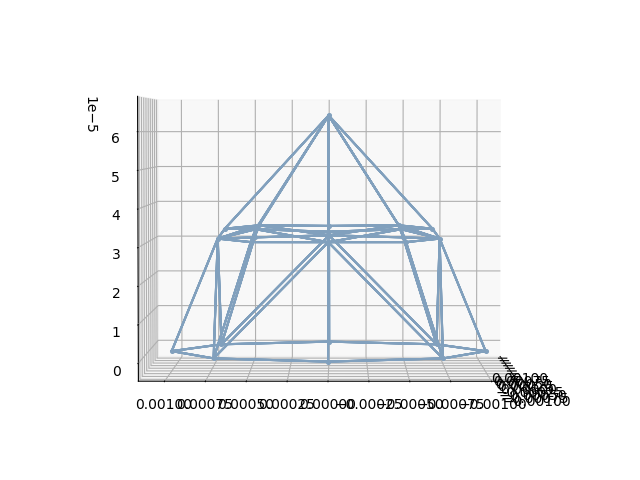

In [111]:

# Initiate a cubical complex
HC = Complex(3, domain=[(-r, r),]*3)
HC.triangulate()

for i in range(1):
    HC.refine_all()

#for v in HC2V:
#    HC.refine_star(v)
del_list = []
for v in HC.V:
    if np.any(v.x_a == -r) or np.any(v.x_a == r):
        if np.any(v.x_a[2] == -r):
            if np.any(v.x_a[0:2] == -r) or  np.any(v.x_a[0:2] == r):
                continue
            else:
                del_list.append(v)
        else:
            continue    
    else:
        del_list.append(v)

for v in del_list:
    HC.V.remove(v)

# Shrink to circle and move to zero
for v in HC.V:
    x = v.x_a[0]
    y = v.x_a[1]
    f_k = [x * np.sqrt(r**2 - y**2/2.0)/r, y * np.sqrt(r**2 - x**2/2.0)/r, v.x_a[2]]
    HC.V.move(v, tuple(f_k)) 
    
# Move up to zero (NOTE: DO NOT DO THIS IN THE CIRCLE LOOP 
# BECUASE SAME VERTEX INDEX BREAKS CONNECTIONS IN LOOP DURING MOVE: 
# TODO: FIX THIS IN THE hyperct LIBRARY CODE)
for v in HC.V:
    if (v.x_a[2] == -r) or (v.x_a[2] == 0.0):
        continue
    f_k = [v.x_a[0], v.x_a[1], v.x_a[2] + r]
    HC.V.move(v, tuple(f_k))  
    
for v in HC.V:
    if (v.x_a[2] == 2*r) or (v.x_a[2] == -r):
        continue
    f_k = [v.x_a[0], v.x_a[1], v.x_a[2] + r]
    HC.V.move(v, tuple(f_k))       
    
for v in HC.V:
    if (v.x_a[2] == 2*r) or (v.x_a[2] == r):
        continue
    f_k = [v.x_a[0], v.x_a[1], v.x_a[2] + r]
    HC.V.move(v, tuple(f_k))     
    
## Move to h
for v in HC.V:
    if (v.x_a[2] == 0.0) or (v.x_a[2] == r):
        continue
    f_k = [v.x_a[0], v.x_a[1], v.x_a[2] + h - 2*r]
    HC.V.move(v, tuple(f_k))  
    
for v in HC.V:
    if (v.x_a[2] == r):
        f_k = [v.x_a[0], v.x_a[1], v.x_a[2] + 0.5*h - r]
        HC.V.move(v, tuple(f_k))  
    
# Find set of boundary vertices
bV = set()
for v in HC.V:
    #print('-')
    #print(f'v.x_a = {v.x_a}')
    #print(f'v.x_a[2] == 0.0 = {v.x_a[2] == 0.0}')
    if v.x_a[2] == 0.0:
        bV.add(v)
        #print(f'bV = {bV}')
    else:
        continue


#axes.set_xlim3d(-(0.1*r + r) , 0.1*r + r)
#axes.set_ylim3d(-(0.1*r + r) , 0.1*r + r)
#axes.set_zlim3d(-(0.1*r + r) , 0.1*r + 2*r)



for i in range(1000):
    HC = mean_flow(HC, bV, m_0, tau=0.00000001, h_0=0.0, gravity_field=True)
    #for j in range(2000):
    #    HC = regularize(HC, bV, tau=0.00001)
 
 
#TODO: FInd droplet height
if 0:
    h_f = 2 *h_jurin
    for v in HC.V:
        if v in bV:
            continue
        else:    
            h_f = min(v.x[2], h_f)
        
fig, axes, fig_s, axes_s = HC.plot_complex(point_color=db,
                                           line_color=db,
                                           complex_color_f=lb,
                                           complex_color_e=db
                                           )

In [48]:
1e-5


1e-05

In [50]:
0.00025 + 1e-5

0.00026000000000000003